### Machine Learning Homework I 

### 2. Principal Component Analysis Implementation

### By Nathmath Huang (bh2821)

* This document is open sourced under Apeche License Version 2.0
* Author: Nathmath Huang (bh2821)
* Date  : March 12, 2025

`P. Libraries`

In [491]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List

In [492]:
# I have cuda
torch.cuda.is_available()

True

In [493]:
# Whether using `numpy` as the backend or `torch`
backend = "numpy"
device = "cpu"

# Feel free to change those parameters since I have debugged and ensured all of them are useful.
# Though, their result may NOT be completely the same.

`P. Matrix Wrapper Library (self-implemented)`

In [494]:
# This matrix class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Matrix:
    """
    A production-level Matrix class that provides a unified interface for common matrix operations used in machine learning.
    The underlying data is stored as either a numpy.ndarray or a torch.Tensor depending on the chosen backend.
    This class supports element-wise arithmetic, matrix multiplication, transpose, determinant, inverse, trace, and SVD.
    Internal optimizations avoid repeated string comparisons by setting boolean flags during initialization.
    """
    __attr__ = "MML.Matrix"    
    
    def __init__(self, data, backend="numpy", *, dtype=None, device=None):
        """
        Initializes a Matrix instance with the specified backend.
        
        Args:
            data (array-like): Input data to be converted into a matrix.
            backend (str): The backend to use ("numpy" or "torch").
            dtype(str): The type of data to be stored in (any type or None).
            device (str): Device where the data is stored on ("cpu" or "cuda", or None).
            
        Raises:
            ValueError: If an unsupported backend is provided.
        """
        self._backend = backend.lower()
        if self._backend not in ("numpy", "torch"):
            raise ValueError("Unsupported backend. Please choose 'numpy' or 'torch'.")
        self._is_numpy = (self._backend == "numpy")
        self._is_torch = (self._backend == "torch")
        
        # Convert input data to the appropriate type.
        # By Nathmath Huang
        if self._is_numpy:
            self.data = np.array(data, dtype=dtype)
        else:
            if torch is None:
                raise ImportError("PyTorch is not installed but backend 'torch' was requested.")
            self.data = data.to(device, dtype=dtype) if isinstance(data, torch.Tensor) else torch.tensor(data, device=device, dtype=dtype)
    
    def __repr__(self):
        """
        Returns a string representation of the Matrix showing the backend, shape, and data.
        """
        return f"Matrix(backend={self._backend}, shape={self.shape}, data=\n{self.data})"
    
    def __getitem__(self, key):
       """
       Allows subscription using a[i, j]. 
       If the result is an array, it returns a new Matrix; otherwise, the scalar value.
       """
       result = self.data[key]
       if (self._is_numpy and isinstance(result, np.ndarray)) or (self._is_torch and torch is not None and isinstance(result, torch.Tensor)):
           return Matrix(result, backend=self._backend)
       return result
   
    def __setitem__(self, key, value):
        """
        Allows assignment using a[i, j] = value.
        If the value is a Matrix instance, its underlying data is used.
        """
        if isinstance(value, Matrix):
            value = value.data
        self.data[key] = value
   
    def submatrix(self, key):
      """
      Retrieves a sub-array of the matrix using the given key while ensuring the result remains two-dimensional.
      For example, using a[:, 1] will return a Matrix of shape (m, 1) rather than (m,).
      
      Args:
          key: Indexing key (can be an int, slice, or tuple of such) for sub-array extraction.
      
      Returns:
          Matrix: A new Matrix instance representing the sub-array with two dimensions.
      """
      result = self.data[key]
      # For numpy backend: if result is 1D but the original matrix is 2D, adjust the shape.
      if self._is_numpy and isinstance(result, np.ndarray):
          if result.ndim == 1 and len(self.data.shape) == 2:
              if isinstance(key, tuple):
                  if len(key) == 2:
                      if isinstance(key[0], slice) and isinstance(key[1], int):
                          # Selecting a column -> reshape to (m, 1)
                          result = result[:, np.newaxis]
                      elif isinstance(key[0], int) and isinstance(key[1], slice):
                          # Selecting a row -> reshape to (1, n)
                          result = result[np.newaxis, :]
                      else:
                          result = np.atleast_2d(result)
                  else:
                      result = np.atleast_2d(result)
              else:
                  # key is a single index (e.g., a[1]) -> treat as row selection.
                  result = result[np.newaxis, :]
      # For torch backend: similar adjustments using unsqueeze.
      elif self._is_torch and torch is not None and isinstance(result, torch.Tensor):
          if result.dim() == 1 and len(self.data.shape) == 2:
              if isinstance(key, tuple):
                  if len(key) == 2:
                      if isinstance(key[0], slice) and isinstance(key[1], int):
                          result = result.unsqueeze(1)  # Make column vector.
                      elif isinstance(key[0], int) and isinstance(key[1], slice):
                          result = result.unsqueeze(0)  # Make row vector.
                      else:
                          result = result.unsqueeze(0)
                  else:
                      result = result.unsqueeze(0)
              else:
                  result = result.unsqueeze(0)
      return Matrix(result, backend=self._backend) 
   
    @property
    def shape(self):
        """
        Returns the shape of the matrix.
        """
        return self.data.shape
    
    @property
    def dtype(self):
        """
        Returns the data type of the matrix elements.
        """
        return self.data.dtype
    
    @property
    def device(self):
        """
        Returns the data device of the matrix elements.
        """
        if self._backend == "numpy":
            return "cpu"
        else:
            return self.data.device.type

    def reshape(self, shape):
        """
        Converts the matrix into a new shape.
        
        Returns:
            Matrix: A new Matrix object with the specified shape.
        """
        return Matrix(self.data.reshape(shape), backend=self._backend)
    
    def astype(self, dtype):
        """
        Converts the underlying data to the specified type.
        
        For the numpy backend, it uses np.ndarray.astype.
        For the torch backend, it maps the input (which can be a torch.dtype, a string, or a numpy type)
        to the corresponding torch dtype and uses tensor.to(dtype=...).
        
        Args:
            dtype: The desired data type. For numpy, any valid numpy dtype is accepted.
                   For torch, this can be a torch.dtype, a string (e.g., "float32", "int64"),
                   or a numpy dtype.
                   
        Returns:
            A new Matrix instance with the data converted to the specified type.
        """
        if self._is_numpy:
            new_data = self.data.astype(dtype)
            return Matrix(new_data, backend="numpy")
        else:
            # Map the input dtype to a torch dtype.
            torch_dtype = None
            if isinstance(dtype, torch.dtype):
                torch_dtype = dtype
            elif isinstance(dtype, str):
                mapping = {
                    "float32": torch.float32,
                    "float": torch.float32,
                    "float64": torch.float64,
                    "double": torch.float64,
                    "int32": torch.int32,
                    "int": torch.int32,
                    "int64": torch.int64,
                    "long": torch.int64,
                    "bool": torch.bool,
                    "complex64": torch.complex64,
                    "complex128": torch.complex128
                }
                if dtype in mapping:
                    torch_dtype = mapping[dtype]
                else:
                    raise ValueError(f"Unsupported dtype string: {dtype}")
            elif isinstance(dtype, (np.dtype, type)):
                np_dtype = np.dtype(dtype)
                mapping = {
                    np.dtype("float32"): torch.float32,
                    np.dtype("float64"): torch.float64,
                    np.dtype("int32"): torch.int32,
                    np.dtype("int64"): torch.int64,
                    np.dtype("bool"): torch.bool,
                    np.dtype("complex64"): torch.complex64,
                    np.dtype("complex128"): torch.complex128,
                }
                if np_dtype in mapping:
                    torch_dtype = mapping[np_dtype]
                else:
                    raise ValueError(f"Unsupported numpy dtype: {np_dtype}")
            else:
                raise ValueError(f"Unsupported dtype argument: {dtype}")
            new_data = self.data.to(dtype=torch_dtype)
            return Matrix(new_data, backend="torch")

    def to(self, backend, *, dtype=None, device=None):
        """
        Converts the matrix to the specified backend and optionally sets the device for torch tensors.
        
        Args:
            backend (str): The target backend ("numpy" or "torch").
            dtype (str, optional): The target type (any numpy or torch type nor None for auto inferenence).
            device (str, optional): The target device for torch tensors (e.g., "cpu" or "cuda").
                                    Ignored if converting to numpy.
        
        Returns:
            Matrix: A new Matrix object with data in the target backend and on the specified device.
        """
        target = backend.lower()
        if target == self._backend:
            # Already in the target backend: for torch, adjust device if specified.
            if self._is_torch:
                new_data = self.data.to(device = device, dtype = dtype)
                return Matrix(new_data, backend="torch")
            return Matrix(self.data, backend=self._backend)
        if target == "numpy":
            # Converting from torch to numpy: always bring to CPU.
            if self._is_torch:
                return Matrix(self.data.cpu().to(dtype = dtype).numpy(), backend="numpy")
        elif target == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            if self._is_numpy:
                new_data = torch.tensor(self.data, device = device, dtype = dtype)
                return Matrix(new_data, backend="torch")
        raise ValueError("Unsupported backend conversion.")

    def to_rational(self):
        """
        Converts all values stored in the matrix to rational numbers (fractions.Fraction).
        For the numpy backend, returns a new Matrix with a numpy array of Fraction objects (dtype=object).
        For the torch backend, due to limitations of torch tensors with non-numeric types,
        the conversion is performed via numpy and the underlying data becomes a numpy array of Fraction objects,
        while the backend attribute is preserved as 'torch'.
        """
        if self._is_numpy:
            vec_func = np.vectorize(lambda x: float(x.real))
            new_data = vec_func(self.data)
            return Matrix(new_data, backend="numpy")
        else:
            # Convert torch tensor to numpy, then to Fraction.
            np_data = self.data.cpu().numpy()
            vec_func = np.vectorize(lambda x: float(x.real))
            new_data = vec_func(np_data)
            # Although backend remains 'torch', data is now a numpy array.
            return Matrix(new_data, backend="torch")

    def to_complex(self):
        """
        Converts all values stored in the matrix to complex numbers.
        For the numpy backend, returns a new Matrix with a numpy array of complex numbers.
        For the torch backend, returns a new Matrix with data converted to a torch complex tensor.
        """
        if self._is_numpy:
            new_data = self.data.astype(complex)
            return Matrix(new_data, backend="numpy")
        else:
            if not torch.is_complex(self.data):
                new_data = self.data.to(torch.complex64)
                return Matrix(new_data, backend="torch")
            return Matrix(self.data, backend="torch")
        
    def _apply_op(self, other, op):
        """
        Internal helper to apply an element-wise binary operation.
        
        Args:
            other (Matrix or scalar): The other operand.
            op (callable): A function that applies the desired operation element-wise.
            
        Returns:
            Matrix: A new Matrix instance with the operation applied.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        result = op(self.data, other_val)
        return Matrix(result, backend=self._backend)
    
    def copy(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current matrix with the specified backend and data type.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Matrix: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Matrix(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Matrix(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Matrix(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Matrix(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def append(self, to_append, axis=0):
        """
        Append a scalar (broadcasted) or an array to the matrix along the specified axis.
        
        Args:
            to_append: A scalar value or an array-like object (or Matrix) to append.
            axis (int): Axis along which to append. For 2D matrices, use axis=0 (append row)
                        or axis=1 (append column).
                        
        Returns:
            Matrix: A new Matrix instance with the appended data.
        """
        orig_shape = self.data.shape
    
        # If to_append is an instance of self, extract its underlying data.
        if isinstance(to_append, type(self)):
            append_data = to_append.data
        else:
            # If to_append is a scalar, create an array of appropriate shape.
            if np.isscalar(to_append):
                if axis == 0:
                    new_shape = (1, orig_shape[1])
                elif axis == 1:
                    new_shape = (orig_shape[0], 1)
                else:
                    raise ValueError("Axis out of bounds. Only axis=0 or axis=1 are supported.")
                if self._is_numpy:
                    append_data = np.full(new_shape, to_append, dtype=self.data.dtype)
                else:
                    append_data = torch.full(new_shape, to_append, dtype=self.data.dtype, device=self.data.device.type)
            # Not a scalar
            else:
                # If the input is a matrix.
                if isinstance(to_append, Matrix):
                    if self._is_numpy:
                        append_data = np.array(to_append.data.copy(), dtype=self.data.dtype)
                    else:
                        append_data = torch.tensor(to_append.data.clone().detach(), dtype=self.data.dtype, device=self.data.device.type)
                    
                # Otherwise, assume to_append is array-like.
                else:
                    if self._is_numpy:
                        append_data = np.array(to_append.copy(), dtype=self.data.dtype)
                    else:
                        append_data = torch.tensor(to_append.clone().detach(), dtype=self.data.dtype, device=self.data.device.type)
                    
                # Validate dimensions (assuming 2D matrices)
                if len(append_data.shape) != len(orig_shape):
                    raise ValueError("Dimension mismatch: appended data must match dimensions of the matrix.")
                if axis == 0:
                    if append_data.shape[1:] != orig_shape[1:]:
                        raise ValueError("Shape mismatch for axis 0: appended array must have the same number of columns.")
                elif axis == 1:
                    if append_data.shape[0] != orig_shape[0]:
                        raise ValueError("Shape mismatch for axis 1: appended array must have the same number of rows.")
                else:
                    raise ValueError("Axis out of bounds. Only axis=0 or axis=1 are supported.")
        
        # Concatenate along the specified axis using the appropriate backend.
        if self._is_numpy:
            new_data = np.concatenate((self.data, append_data), axis=axis)
        else:
            new_data = torch.cat((self.data, append_data), dim=axis)
        
        return Matrix(new_data, backend=self._backend)

    
    def __add__(self, other):
        """
        Element-wise addition.
        """
        return self._apply_op(other, lambda a, b: a + b)
    
    def __radd__(self, other):
        """
        Right-hand element-wise addition.
        """
        return self.__add__(other)
    
    def __sub__(self, other):
        """
        Element-wise subtraction.
        """
        return self._apply_op(other, lambda a, b: a - b)
    
    def __rsub__(self, other):
        """
        Right-hand element-wise subtraction.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        return Matrix(other_val - self.data, backend=self._backend)
    
    def __mul__(self, other):
        """
        Element-wise multiplication.
        """
        return self._apply_op(other, lambda a, b: a * b)
    
    def __rmul__(self, other):
        """
        Right-hand element-wise multiplication.
        """
        return self.__mul__(other)
    
    def __truediv__(self, other):
        """
        Element-wise true division.
        """
        return self._apply_op(other, lambda a, b: a / b)
    
    def __rtruediv__(self, other):
        """
        Right-hand element-wise true division.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        return Matrix(other_val / self.data, backend=self._backend)
    
    def __matmul__(self, other):
        """
        Matrix multiplication using the @ operator.
        
        Args:
            other (Matrix or array-like): The matrix to multiply with.
            
        Returns:
            Matrix: The result of the matrix multiplication.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        result = self.data @ other_val
        return Matrix(result, backend=self._backend)
    
    def __pow__(self, to_power):
        """Element-wise power."""
        return self._apply_op(to_power, lambda a, b: a ** b)

    def __rpow__(self, other):
        """Right-hand element-wise power."""
        return self.__mul__(other)
    
    def __neg__(self):
        """
        Returns the negation of the matrix.
        """
        return Matrix(-self.data, backend=self._backend)
    
    def mean(self, axis = None):
        """
        Computes the mean of the matrix along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the mean. If None, computes the mean across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed mean values.
    
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.mean(self.data, axis=axis)
        else:
            result = torch.mean(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def std(self, axis = None):
        """
        Computes the standard deviation of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the standard deviation. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed standard deviation values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.std(self.data, axis=axis)
        else:
            result = torch.std(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def var(self, axis = None):
        """
        Computes the variance of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the variance. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed variance values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.var(self.data, axis=axis)
        else:
            result = torch.var(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def min(self, axis = None):
        """
        Computes the minimum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the minimum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed minimum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.min(self.data)
            else:
                result = np.min(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.min(self.data)
            else:
                result = torch.min(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def max(self, axis = None):
        """
        Computes the maximum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the maximum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed maximum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.max(self.data)
            else:
                result = np.max(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.max(self.data)
            else:
                result = torch.max(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def sum(self, axis = None):
        """
        Computes the sum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the sum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.sum(self.data, axis=axis)
        else:
            result = torch.sum(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def cumsum(self, axis = None):
        """
        Computes the cumulative sum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative sum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed cumulative sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumsum(self.data, axis=axis)
        else:
            result = torch.cumsum(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def prod(self, axis = None):
        """
        Computes the product of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the product. If None, computes across all dimensions.
    
        Returns:
            Matrix: A new instance containing the computed product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.prod(self.data, axis=axis)
        else:
            result = torch.prod(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def cumprod(self, axis = None):
        """
        Computes the cumulative product of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative product. If None, computes across all dimensions.
    
        Returns:
            Matrix: A new instance containing the computed cumulative product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumprod(self.data, axis=axis)
        else:
            result = torch.cumprod(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def exp(self):
        """
        Computes the element-wise exponential.
        
        Returns:
            Matrix: New matrix with exponential applied.
        """
        if self._is_numpy:
            result = np.exp(self.data)
        else:
            result = torch.exp(self.data)
        return Matrix(result, backend=self._backend)
    
    def sin(self):
        """
        Computes the element-wise sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sin(self.data)
        else:
            result = torch.sin(self.data)
        return Matrix(result, backend=self._backend)
    
    def cos(self):
        """
        Computes the element-wise cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cos(self.data)
        else:
            result = torch.cos(self.data)
        return Matrix(result, backend=self._backend)
    
    def tan(self):
        """
        Computes the element-wise tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tan(self.data)
        else:
            result = torch.tan(self.data)
        return Matrix(result, backend=self._backend)
    
    def sinh(self):
        """
        Computes the element-wise hyperbolic sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sinh(self.data)
        else:
            result = torch.sinh(self.data)
        return Matrix(result, backend=self._backend)
    
    def cosh(self):
        """
        Computes the element-wise hyperbolic cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cosh(self.data)
        else:
            result = torch.cosh(self.data)
        return Matrix(result, backend=self._backend)
    
    def tanh(self):
        """
        Computes the element-wise hyperbolic tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tanh(self.data)
        else:
            result = torch.tanh(self.data)
        return Matrix(result, backend=self._backend)
    
    def abs(self):
        """
        Computes the element-wise absolute values.
        
        Returns:
            Matrix: New matrix with absolute values applied.
        """
        if self._is_numpy:
            result = np.abs(self.data)
        else:
            result = torch.abs(self.data)
        return Matrix(result, backend=self._backend)
    
    def log(self):
        """
        Computes the element-wise natural logarithm.
        
        Returns:
            Matrix: New matrix with logarithm applied.
        """
        if self._is_numpy:
            result = np.log(self.data)
        else:
            result = torch.log(self.data)
        return Matrix(result, backend=self._backend)
    
    def logistic(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the logistic (sigmoid) function element-wise on the input Matrix.
        
        f(x) = L / (1 + exp(-k*(x - x0)))
        
        Args:
            L (float): The curve's maximum value.
            k (float): The steepness of the curve.
            x0 (float): The x-value of the sigmoid's midpoint.
        
        Returns:
            Matrix: A new Matrix with the logistic function applied element-wise.
        """
        if self._is_numpy:
            result = L / (1.0 + np.exp(-k * (self.data - x0)))
        else:
            result = L / (1.0 + torch.exp(-k * (self.data - x0)))
        return Matrix(result, backend=self._backend)
    
    def logistic_inv(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the inverse of the logistic (sigmoid) function element-wise on the input Matrix.
        
        f⁻¹(y) = x0 - (1/k)*ln((L - y)/y)
        
        Args:
            L (float): The curve's maximum value used in the logistic function.
            k (float): The steepness of the curve used in the logistic function.
            x0 (float): The sigmoid's midpoint used in the logistic function.
        
        Returns:
            Matrix: A new Matrix with the inverse logistic function applied element-wise.
        """
        if self._is_numpy:
            result = x0 - (1/k) * np.log((L - self.data) / self.data)
        else:
            result = x0 - (1/k) * torch.log((L - self.data) / self.data)
        return Matrix(result, backend=self._backend)
    
    def flatten(self, major = "row"):
        """
        Returns the flattened matrix.
        
        Returns:
            Matrix: The flattened matrix.
        """
        if major == "col":
            x = self.transpose()
            return Matrix(x.data.flatten(), backend=self._backend)
        elif major == "row":
            return Matrix(self.data.flatten(), backend=self._backend)
        else:
            raise ValueError("major must be either 'row' or 'column'!")
    
    def transpose(self):
        """
        Returns the transpose of the matrix.
        
        Returns:
            Matrix: The transposed matrix.
        """
        if self._is_numpy:
            result = self.data.T
        else:
            result = self.data.transpose(1, 0)
        if len(self.shape) > 1:
            return Matrix(result.reshape(
                self.shape[1], self.shape[0]), backend=self._backend)
        else:
            # From a row vector to a column vector
            return Matrix(result.reshape([1, self.shape[0]]), backend=self._backend)
    
    def _eigen_kernel(self):
        """
        Calculates eigenvalues and eigenvectors using internal libraries (numpy or torch).
        
        Returns:
            Matrix: eigen_values, eigen_vectors: The computed eigenvalues and eigenvectors.
        """
        if self.shape[0] != self.shape[1]:
            raise ValueError("Eigen decomposition requires a square matrix.")
        if self._is_numpy:
            eigen_values, eigen_vectors = np.linalg.eig(self.data)
        else:
            # Using torch.linalg.eig (available in newer versions of PyTorch)
            eigen_values, eigen_vectors = torch.linalg.eig(self.data)
        return Matrix(eigen_values, backend=self._backend), Matrix(eigen_vectors, backend=self._backend)

    def _jacobi_eigen(self, tol=1e-10, max_iterations=1000):
        """
        Eigen decomposition using the Jacobi rotation method for symmetric matrices.
        
        Returns:
            eigen_values, eigen_vectors: Sorted in descending order.
        """
        A = self.data.astype(float).copy()
        n = A.shape[0]
        V = np.eye(n)
        for iteration in range(max_iterations):
            p, q = 0, 1
            max_val = 0
            for i in range(n):
                for j in range(i+1, n):
                    if abs(A[i, j]) > max_val:
                        max_val = abs(A[i, j])
                        p, q = i, j
            if max_val < tol:
                break
            if abs(A[p, p] - A[q, q]) < tol:
                theta = np.pi / 4
            else:
                theta = 0.5 * np.arctan2(2 * A[p, q], A[q, q] - A[p, p])
            c = np.cos(theta)
            s = np.sin(theta)
            app, aqq, apq = A[p, p], A[q, q], A[p, q]
            A[p, p] = c**2 * app - 2 * s * c * apq + s**2 * aqq
            A[q, q] = s**2 * app + 2 * s * c * apq + c**2 * aqq
            A[p, q] = 0.0
            A[q, p] = 0.0
            for i in range(n):
                if i != p and i != q:
                    aip, aiq = A[i, p], A[i, q]
                    A[i, p] = c * aip - s * aiq
                    A[p, i] = A[i, p]
                    A[i, q] = s * aip + c * aiq
                    A[q, i] = A[i, q]
            for i in range(n):
                vip, viq = V[i, p], V[i, q]
                V[i, p] = c * vip - s * viq
                V[i, q] = s * vip + c * viq
        eigen_values = np.diag(A)
        idx = np.argsort(eigen_values)[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = V[:, idx]
        return Matrix(eigen_values, backend=self._backend), Matrix(eigen_vectors, backend=self._backend)

    def _qr_eigen_nonsymmetric(self, tol=1e-10, max_iterations=1000):
        """
        Eigen decomposition for non-symmetric matrices using a basic QR algorithm
        for eigenvalues and SVD-based extraction for eigenvectors.
        
        Returns:
            eigen_values, eigen_vectors: Sorted in descending order by modulus.
        """
        # Work in complex to capture possible complex eigenvalues.
        A_orig = np.array(self.data, dtype=complex)
        n = A_orig.shape[0]
        A = A_orig.copy()
        for _ in range(max_iterations):
            Q, R = np.linalg.qr(A)
            A = R @ Q
            off_diag = A - np.diag(np.diag(A))
            if np.linalg.norm(off_diag) < tol:
                break
        eigen_values = np.diag(A)
        # Compute eigenvectors by solving (A_orig - lambda I)v = 0 via SVD.
        eigen_vectors = np.empty((n, n), dtype=complex)
        for j, lam in enumerate(eigen_values):
            B = A_orig - lam * np.eye(n, dtype=complex)
            U, S, Vh = np.linalg.svd(B)
            v = Vh.conj().T[:, -1]
            v = v / np.linalg.norm(v)
            eigen_vectors[:, j] = v
        # Sort eigenpairs by descending modulus of eigenvalues.
        idx = np.argsort(np.abs(eigen_values))[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = eigen_vectors[:, idx]
        return Matrix(eigen_values, backend = self._backend), Matrix(eigen_vectors, backend = self._backend)

    def eigen(self, method="kernel", symmetric=None, tol=1e-10, max_iterations=1000):
        """
        Unified eigen decomposition method.
        
        Args:
            method (str): "kernel" to use internal libraries; "selfimpl" to use the self-implemented solver.
            symmetric (bool, optional): If known symmetric; if None, determined automatically.
            tol (float): Tolerance for convergence (used in self-implementation).
            max_iterations (int): Maximum iterations (used in self-implementation).
        
        Returns:
            eigen_values, eigen_vectors: eigenvalues and eigenvectors.
        """
        if self.shape[0] != self.shape[1]:
            raise ValueError("Eigen decomposition requires a square matrix.")
        # Determine symmetry if not explicitly provided.
        if symmetric is None:
            if self._is_numpy:
                symmetric = np.allclose(self.data, self.data.T, atol=tol)
            else:
                symmetric = torch.allclose(self.data, self.data.T)
                
        if method == "kernel":
            return self._eigen_kernel()
        
        elif method == "selfimpl":
            if self._is_numpy:
                if symmetric:
                    return self._jacobi_eigen(tol, max_iterations)
                else:
                    return self._qr_eigen_nonsymmetric(tol, max_iterations)
            else:
                # Use kernel instead
                return self._eigen_kernel()
        else:
            raise ValueError("Unknown eigen method. Use 'kernel' or 'selfimpl'.")

    def _check_square(self):
        """
        Internal helper to ensure the matrix is square (required for determinant, inverse, and trace).
        
        Raises:
            ValueError: If the matrix is not square.
        """
        if len(self.shape) != 2 or self.shape[0] != self.shape[1]:
            raise ValueError("This operation requires a square matrix.")
    
    def determinant(self):
        """
        Computes the determinant of a square matrix.
        
        Returns:
            Scalar: The determinant value.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return np.linalg.det(self.data)
        else:
            return torch.det(self.data)
    
    def inverse(self):
        """
        Computes the inverse of a square matrix.
        
        Returns:
            Matrix: The inverse matrix.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            inv_data = np.linalg.inv(self.data)
        else:
            inv_data = torch.inverse(self.data)
        return Matrix(inv_data, backend=self._backend)
    
    def trace(self):
        """
        Computes the trace of a square matrix (sum of diagonal elements).
        
        Returns:
            Scalar: The trace value.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return np.trace(self.data)
        else:
            return torch.trace(self.data)
    
    def diag(self):
        """
        Computes the diagonal vector of a square matrix.
        
        Returns:
            Matrix: The diagonal vector.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return Matrix(np.diag(self.data), backend=self._backend)
        else:
            return Matrix(torch.diag(self.data), backend=self._backend)
    
    def dot(self, other):
        """
        Computes the dot product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the dot product.
        """
        if self._is_numpy:
            return Matrix(np.dot(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.matmul(self.data, other.data), backend="torch")
    
    def inner(self, other):
        """
        Computes the inner product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the inner product.
        """
        if self._is_numpy:
            return Matrix(np.inner(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.inner(self.data, other.data), backend="torch")
    
    def outer(self, other):
        """
        Computes the outer product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the outer product.
        """
        if self._is_numpy:
            return Matrix(np.outer(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.outer(self.data, other.data), backend="torch")
    
    def svd(self, full_matrices=True):
        """
        Computes the Singular Value Decomposition (SVD) of the matrix.
        
        Args:
            full_matrices (bool): If True, compute the full SVD; otherwise, compute the reduced SVD.
            
        Returns:
            Tuple[Matrix, Matrix, Matrix]: A tuple containing U, S, and V^T as Matrix objects.
        """
        if self._is_numpy:
            U, S, Vh = np.linalg.svd(self.data, full_matrices=full_matrices)
            return Matrix(U, backend="numpy"), Matrix(S, backend="numpy"), Matrix(Vh, backend="numpy")
        else:
            if hasattr(torch.linalg, 'svd'):
                U, S, Vh = torch.linalg.svd(self.data, full_matrices=full_matrices)
            else:
                U, S, V = torch.svd(self.data, some=not full_matrices)
                Vh = V.t()
            return Matrix(U, backend="torch"), Matrix(S, backend="torch"), Matrix(Vh, backend="torch")
    
    @staticmethod
    def zeros(shape, backend="numpy", dtype=None):
        """
        Creates a matrix filled with zeros.
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix of zeros.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.zeros(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def ones(shape, backend="numpy", dtype=None):
        """
        Creates a matrix filled with ones.
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix of ones.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.ones(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def identity(n, backend="numpy", dtype=None):
        """
        Creates an identity matrix of size n x n.
        
        Args:
            n (int): The number of rows and columns.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: An identity matrix.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.eye(n, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.eye(n, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def rand(shape, backend="numpy", dtype=None):
        """
        Creates a matrix with random values uniformly distributed in [0, 1).
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix with random values.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.random.rand(*shape)
            if dtype:
                data = data.astype(dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.rand(shape, dtype=dtype) if dtype else torch.rand(shape)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)

    @staticmethod
    def least_square(X, Y, backend="numpy", dtype=None):
        """
        Solves the linear system bX = Y using the normal equation approach.
        
        Args:
            X (Matrix): The matrix of features or independent variables.
            Y (Matrix): The matrix of observations or dependent variables.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type for the result.
            
        Returns:
            Matrix: The least-squares solution b satisfying bX = Y
        """    
        # Check if the matrix Y is with one column or not
        if len(Y.shape) == 1:
            Y = Y.reshape([Y.shape[0], 1])
        if Y.shape[1] != 1:
            raise ValueError("The input matrix Y must be of 1 column!")
        
        # Compute the least-squares solution (X^T@X)^-1@X^T@Y
        X_transpose = X.transpose()
        b = (X_transpose @ X).inverse() @ X_transpose @ Y
        if dtype:
            b = b.astype(dtype)
            
        return b


`P. Tensor Wrapper Library (self-implemented) [Not used directly by PCA here]`

In [495]:
# This tensor class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Tensor:
    """
    A production-level Tensor class providing a unified interface for common machine learning operations.
    This class supports either a numpy.ndarray or a torch.Tensor as its underlying backend. To optimize performance,
    the backend string is processed once at initialization, and boolean flags (_is_numpy and _is_torch) are used to 
    avoid repeated string comparisons.
    
    The implemented operations include element-wise arithmetic, matrix multiplication, reshaping, reductions (sum, mean, 
    max, min), and element-wise exponential and logarithmic functions.
    
    Attributes:
        data (np.ndarray or torch.Tensor): Underlying storage for tensor data.
        _backend (str): Lowercase string for the backend ("numpy" or "torch").
        _is_numpy (bool): True if using numpy as the backend.
        _is_torch (bool): True if using torch as the backend.
    """
    
    __attr__ = "MML.Tensor"    
    
    def __init__(self, data, backend="numpy", *, dtype=None, device=None):
        """
        Initializes a Tensor instance with the specified backend.
        
        Args:
            data (array-like): Input data to be converted into a tensor.
            backend (str): Backend to use ("numpy" or "torch").
            dtype(str): The type of data to be stored in (any type or None).
            device (str): Device where the data is stored on ("cpu" or "cuda", or None).
            
        Raises:
            ValueError: If an unsupported backend is specified.
        """
        self._backend = backend.lower()
        if self._backend not in ("numpy", "torch"):
            raise ValueError("Unsupported backend. Please choose 'numpy' or 'torch'.")
        self._is_numpy = (self._backend == "numpy")
        self._is_torch = (self._backend == "torch")
        
        # Convert input data to the appropriate tensor type.
        if self._is_numpy:
            self.data = np.array(data, dtype=dtype)
        else:
            if torch is None:
                raise ImportError("PyTorch is not installed but backend 'torch' was requested.")
            self.data = data.to(device, dtype=dtype) if isinstance(data, torch.Tensor) else torch.tensor(data, device=device, dtype=dtype)

    def __repr__(self):
        """
        Returns a string representation showing backend, shape, and data.
        """
        return f"Tensor(backend={self._backend}, shape={self.shape}, data=\n{self.data})"

    def __getitem__(self, key):
       """
       Allows subscription using a[i, j]. 
       If the result is an array, it returns a new Tensor; otherwise, the scalar value.
       """
       result = self.data[key]
       if (self._is_numpy and isinstance(result, np.ndarray)) or (self._is_torch and torch is not None and isinstance(result, torch.Tensor)):
           return Tensor(result, backend=self._backend)
       return result
   
    def __setitem__(self, key, value):
        """
        Allows assignment using a[i, j] = value.
        If the value is a Tensor instance, its underlying data is used.
        """
        if isinstance(value, Tensor):
            value = value.data
        self.data[key] = value

    @property
    def shape(self):
        """
        Retrieves the shape of the tensor.
        """
        return self.data.shape

    @property
    def dtype(self):
        """
        Retrieves the data type of the tensor elements.
        """
        return self.data.dtype
        
    @property
    def device(self):
        """
        Returns the data device of the tensor elements.
        """
        if self._backend == "numpy":
            return "cpu"
        else:
            return self.data.device.type
    
    def reshape(self, shape):
        """
        Converts the tensor into a new shape.
        
        Returns:
            Tensor: A new Tensor object with the specified shape.
        """
        return Tensor(self.data.reshape(shape), backend=self._backend)
    
    def astype(self, dtype):
        """
        Converts the underlying data to the specified type.
        
        For the numpy backend, it uses np.ndarray.astype.
        For the torch backend, it maps the input (which can be a torch.dtype, a string, or a numpy type)
        to the corresponding torch dtype and uses tensor.to(dtype=...).
        
        Args:
            dtype: The desired data type. For numpy, any valid numpy dtype is accepted.
                   For torch, this can be a torch.dtype, a string (e.g., "float32", "int64"),
                   or a numpy dtype.
                   
        Returns:
            A new Matrix instance with the data converted to the specified type.
        """
        if self._is_numpy:
            new_data = self.data.astype(dtype)
            return Tensor(new_data, backend="numpy")
        else:
            # Map the input dtype to a torch dtype.
            torch_dtype = None
            if isinstance(dtype, torch.dtype):
                torch_dtype = dtype
            elif isinstance(dtype, str):
                mapping = {
                    "float32": torch.float32,
                    "float": torch.float32,
                    "float64": torch.float64,
                    "double": torch.float64,
                    "int32": torch.int32,
                    "int": torch.int32,
                    "int64": torch.int64,
                    "long": torch.int64,
                    "bool": torch.bool,
                    "complex64": torch.complex64,
                    "complex128": torch.complex128
                }
                if dtype in mapping:
                    torch_dtype = mapping[dtype]
                else:
                    raise ValueError(f"Unsupported dtype string: {dtype}")
            elif isinstance(dtype, (np.dtype, type)):
                np_dtype = np.dtype(dtype)
                mapping = {
                    np.dtype("float32"): torch.float32,
                    np.dtype("float64"): torch.float64,
                    np.dtype("int32"): torch.int32,
                    np.dtype("int64"): torch.int64,
                    np.dtype("bool"): torch.bool,
                    np.dtype("complex64"): torch.complex64,
                    np.dtype("complex128"): torch.complex128,
                }
                if np_dtype in mapping:
                    torch_dtype = mapping[np_dtype]
                else:
                    raise ValueError(f"Unsupported numpy dtype: {np_dtype}")
            else:
                raise ValueError(f"Unsupported dtype argument: {dtype}")
            new_data = self.data.to(dtype=torch_dtype)
            return Tensor(new_data, backend="torch")
    
    def to(self, backend, *, dtype = None, device=None):
        """
        Converts the tensor to the specified backend and moves it to the specified device.
        
        Args:
            backend (str): The target backend ("numpy" or "torch").
            dtype (str, optional): The target type (any numpy or torch type nor None for auto inferenence).
            device (str, optional): The target device ("cpu" or "cuda"). This parameter is only applicable when the target or source is torch.
            
        Returns:
            Tensor: A new Tensor object with data in the target backend and on the specified device.
        """
        target = backend.lower()
        # If the target backend is the same as the current one.
        if target == self._backend:
            if self._is_torch:
                # If already torch tensor, just move it to the desired device.
                return Tensor(self.data.to(device, dtype = dtype), backend="torch")
            return Tensor(self.data, backend=self._backend)
        
        # Convert to numpy if requested.
        if target == "numpy":
            if self._is_torch:
                # Move to CPU first (numpy only works on CPU) then convert to numpy.
                return Tensor(self.data.cpu().to(dtype = dtype).numpy(), backend="numpy")
        
        # Convert to torch if requested.
        elif target == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            if self._is_numpy:
                # Create a torch tensor from numpy array.
                tensor = torch.tensor(self.data, dtype = dtype, device = device)
            else:
                tensor = self.data
            return Tensor(tensor, backend="torch")
        
        raise ValueError("Unsupported backend conversion.")

    def _apply_op(self, other, op):
        """
        Helper method to apply an element-wise binary operation.
        
        Args:
            other (Tensor or scalar): Other operand.
            op (callable): Function applying the desired operation element-wise.
            
        Returns:
            Tensor: New Tensor resulting from the operation.
        """
        other_val = other.data if isinstance(other, Tensor) else other
        result = op(self.data, other_val)
        return Tensor(result, backend=self._backend)
    
    def copy(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current tensor with the specified backend and data type.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Tensor: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Tensor(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Tensor(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def append(self, to_append, axis=0):
        """
        Append a scalar (broadcasted) or an array to the matrix along the specified axis.
        The tensor is a general n-dimensional tensor, so the appended data must have the same 
        shape as the original tensor on all axes except the specified axis.
    
        Args:
            to_append: A scalar or an array-like object (or Tensor instance) to append.
            axis (int): Axis along which to append. Negative values are supported.
    
        Returns:
            Tensor: A new Tensor instance with the appended data.
        """
        # Get number of dimensions and normalize the axis.
        n_dim = len(self.data.shape)
        if axis < 0:
            axis = axis % n_dim
        if axis >= n_dim:
            raise ValueError(f"Axis {axis} out of bounds for array with {n_dim} dimensions.")
    
        orig_shape = self.data.shape
    
        # If to_append is a Tensor instance, extract its data.
        if isinstance(to_append, type(self)):
            appended_data = to_append.data
        else:
            # If to_append is a scalar, create an array/tensor with shape matching the original
            # on every axis except the specified axis (which will be 1).
            if np.isscalar(to_append):
                new_shape = tuple(1 if i == axis else orig_shape[i] for i in range(n_dim))
                if self._is_numpy:
                    appended_data = np.full(new_shape, to_append, dtype=self.data.dtype)
                else:
                    appended_data = torch.full(new_shape, to_append, dtype=self.data.dtype, device=self.data.device)
            elif isinstance(to_append, Tensor):
                # Convert to array/tensor using the appropriate backend.
                if self._is_numpy:
                    appended_data = np.array(to_append.data.copy(), dtype=self.data.dtype)
                else:
                    appended_data = torch.tensor(to_append.data.clone().detach(), dtype=self.data.dtype, device=self.data.device)
            else:
                # Convert to array/tensor using the appropriate backend.
                if self._is_numpy:
                    appended_data = np.array(to_append.copy(), dtype=self.data.dtype)
                else:
                    appended_data = torch.tensor(to_append.clone().detach(), dtype=self.data.dtype, device=self.data.device)
        
        # If appended_data has one less dimension, expand it along the specified axis.
        if len(appended_data.shape) == n_dim - 1:
            if self._is_numpy:
                appended_data = np.expand_dims(appended_data, axis=axis)
            else:
                appended_data = torch.unsqueeze(appended_data, dim=axis)
        elif len(appended_data.shape) != n_dim:
            raise ValueError("Appended data must have either the same number of dimensions as the original Tensor or one less.")
        
        # Validate shape compatibility: for all dimensions except the specified axis, sizes must match.
        for i in range(n_dim):
            if i != axis and appended_data.shape[i] != orig_shape[i]:
                raise ValueError(f"Shape mismatch at dimension {i}: expected {orig_shape[i]}, got {appended_data.shape[i]}.")
        
        # Concatenate along the specified axis.
        if self._is_numpy:
            new_data = np.concatenate((self.data, appended_data), axis=axis)
        else:
            new_data = torch.cat((self.data, appended_data), dim=axis)
        
            # Return a new Matrix instance with the updated data.
        return Tensor(new_data, backend=self._backend)

    def __add__(self, other):
        """Element-wise addition."""
        return self._apply_op(other, lambda a, b: a + b)

    def __radd__(self, other):
        """Right-hand element-wise addition."""
        return self.__add__(other)

    def __sub__(self, other):
        """Element-wise subtraction."""
        return self._apply_op(other, lambda a, b: a - b)

    def __rsub__(self, other):
        """Right-hand element-wise subtraction."""
        other_val = other.data if isinstance(other, Tensor) else other
        return Tensor(other_val - self.data, backend=self._backend)

    def __mul__(self, other):
        """Element-wise multiplication."""
        return self._apply_op(other, lambda a, b: a * b)

    def __rmul__(self, other):
        """Right-hand element-wise multiplication."""
        return self.__mul__(other)

    def __truediv__(self, other):
        """Element-wise true division."""
        return self._apply_op(other, lambda a, b: a / b)

    def __rtruediv__(self, other):
        """Right-hand element-wise true division."""
        other_val = other.data if isinstance(other, Tensor) else other
        return Tensor(other_val / self.data, backend=self._backend)
    
    def __pow__(self, to_power):
        """Element-wise power."""
        return self._apply_op(to_power, lambda a, b: a ** b)

    def __rpow__(self, other):
        """Right-hand element-wise power."""
        return self.__mul__(other)

    def __matmul__(self, other):
        """
        Matrix multiplication using the @ operator.
        
        Uses the backend's built-in matmul operator.
        """
        other_val = other.data if isinstance(other, Tensor) else other
        result = self.data @ other_val
        return Tensor(result, backend=self._backend)

    def __neg__(self):
        """Negates the tensor element-wise."""
        return Tensor(-self.data, backend=self._backend)
    
    def mean(self, axis = None):
        """
        Computes the mean of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the mean. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed mean values.
        
        """
        if self._is_numpy:
            result = np.mean(self.data, axis=axis)
        else:
            result = torch.mean(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def std(self, axis = None):
        """
        Computes the standard deviation of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the standard deviation. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed standard deviation values.
        
        """
        if self._is_numpy:
            result = np.std(self.data, axis=axis)
        else:
            result = torch.std(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def var(self, axis = None):
        """
        Computes the variance of the Tensor along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the variance. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed variance values.
        
        """
        if self._is_numpy:
            result = np.var(self.data, axis=axis)
        else:
            result = torch.var(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def min(self, axis = None):
        """
        Computes the minimum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the minimum. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed minimum values.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.min(self.data)
            else:
                result = np.min(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.min(self.data)
            else:
                result = torch.min(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def max(self, axis = None):
        """
        Computes the maximum of the Tensor along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the maximum. If None, computes the maximum over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed maximum values.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.max(self.data)
            else:
                result = np.max(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.max(self.data)
            else:
                result = torch.max(self.data, dim=axis)
        return Tensor(result, backend=self._backend)

    def sum(self, axis = None):
        """
        Computes the sum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the sum. If None, computes across all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.sum(self.data, axis=axis)
        else:
            result = torch.sum(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def cumsum(self, axis = None):
        """
        Computes the cumulative sum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative sum. If None, computes across all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed cumulative sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumsum(self.data, axis=axis)
        else:
            result = torch.cumsum(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def prod(self, axis = None):
        """
        Computes the product of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the product. If None, computes across all dimensions.
    
        Returns:
            Tensor: A new instance containing the computed product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.prod(self.data, axis=axis)
        else:
            result = torch.prod(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def cumprod(self, axis = None):
        """
        Computes the cumulative product of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative product. If None, computes across all dimensions.
    
        Returns:
            Tensor: A new instance containing the computed cumulative product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumprod(self.data, axis=axis)
        else:
            result = torch.cumprod(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def logistic(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the logistic (sigmoid) function element-wise on the input Tensor.
        
        f(x) = L / (1 + exp(-k*(x - x0)))
        
        Args:
            L (float): The curve's maximum value.
            k (float): The steepness of the curve.
            x0 (float): The x-value of the sigmoid's midpoint.
        
        Returns:
            Tensor: A new Tensor with the logistic function applied element-wise.
        """
        if self._is_numpy:
            result = L / (1.0 + np.exp(-k * (self.data - x0)))
        else:
            result = L / (1.0 + torch.exp(-k * (self.data - x0)))
        return Tensor(result, backend=self._backend)
    
    def logistic_inv(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the inverse of the logistic (sigmoid) function element-wise on the input Tensor.
        
        f⁻¹(y) = x0 - (1/k)*ln((L - y)/y)
        
        Args:
            L (float): The curve's maximum value used in the logistic function.
            k (float): The steepness of the curve used in the logistic function.
            x0 (float): The sigmoid's midpoint used in the logistic function.
        
        Returns:
            Tensor: A new Tensor with the inverse logistic function applied element-wise.
        """
        if self._is_numpy:
            result = x0 - (1/k) * np.log((L - self.data) / self.data)
        else:
            result = x0 - (1/k) * torch.log((L - self.data) / self.data)
        return Tensor(result, backend=self._backend)
    
    def exp(self):
        """
        Computes the element-wise exponential.
        
        Returns:
            Tensor: New tensor with exponential applied.
        """
        if self._is_numpy:
            result = np.exp(self.data)
        else:
            result = torch.exp(self.data)
        return Tensor(result, backend=self._backend)
    
    def sin(self):
        """
        Computes the element-wise sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sin(self.data)
        else:
            result = torch.sin(self.data)
        return Tensor(result, backend=self._backend)
    
    def cos(self):
        """
        Computes the element-wise cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cos(self.data)
        else:
            result = torch.cos(self.data)
        return Tensor(result, backend=self._backend)
    
    def tan(self):
        """
        Computes the element-wise tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tan(self.data)
        else:
            result = torch.tan(self.data)
        return Tensor(result, backend=self._backend)
    
    def sinh(self):
        """
        Computes the element-wise hyperbolic sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sinh(self.data)
        else:
            result = torch.sinh(self.data)
        return Tensor(result, backend=self._backend)
    
    def cosh(self):
        """
        Computes the element-wise hyperbolic cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cosh(self.data)
        else:
            result = torch.cosh(self.data)
        return Tensor(result, backend=self._backend)
    
    def tanh(self):
        """
        Computes the element-wise hyperbolic tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tanh(self.data)
        else:
            result = torch.tanh(self.data)
        return Tensor(result, backend=self._backend)
    
    def abs(self):
        """
        Computes the element-wise absolute values.
        
        Returns:
            Tensor: New tensor with absolute values applied.
        """
        if self._is_numpy:
            result = np.abs(self.data)
        else:
            result = torch.abs(self.data)
        return Tensor(result, backend=self._backend)
    
    def log(self):
        """
        Computes the element-wise natural logarithm.
        
        Returns:
            Tensor: New tensor with logarithm applied.
        """
        if self._is_numpy:
            result = np.log(self.data)
        else:
            result = torch.log(self.data)
        return Tensor(result, backend=self._backend)
    
    def flatten(self):
        """
        Returns the flattened tensor.
        
        Returns:
            Matrix: The flattened tensor.
        """
        return Tensor(self.data.flatten(), backend=self._backend)
    
    def transpose(self, *axes):
        """
        Transposes the tensor dimensions. If axes are provided, permutes accordingly; otherwise, reverses dimensions.
        
        Args:
            *axes: Optional permutation of dimensions.
            
        Returns:
            Tensor: New transposed tensor.
        """
        if self._is_numpy:
            result = self.data.transpose(axes) if axes else self.data.T
        else:
            result = self.data.permute(*axes) if axes else self.data.permute(*reversed(range(self.data.dim())))
        return Tensor(result, backend=self._backend)
    
    def determinant(self):
        """
        Computes the determinant if the tensor is a matrix.
        
        Returns:
            Tensor: New tensor of determinant.
        """
        if self._is_numpy:
            return np.linalg.det(self.data)
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'det'):
                return torch.linalg.det(self.data)
            else:
                return torch.det(self.data)
            
    def inverse(self):
        """
        Computes the inverse of a tensor.
        
        Returns:
            Tensor: New tensor with its inversed stored.
        """
        if self._is_numpy:
            result = np.linalg.inv(self.data)
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'inv'):
                result = torch.linalg.inv(self.data)
            else:
                result = torch.inverse(self.data)
        return Tensor(result, backend=self._backend)

    def trace(self):
        """
        Computes the trace of a tensor.
        
        Returns:
            Tensor: New tensor with trace stored.
        """
        if self._is_numpy:
            return np.trace(self.data)
        else:
            return torch.trace(self.data)
        
    def dot(self, other):
        """
        Computes the dot product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the dot product.
        """
        if self._is_numpy:
            return Tensor(np.dot(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.matmul(self.data, other.data), backend="torch")
        
    def inner(self, other):
        """
        Computes the inner product of this Tensor with another Tensor.
        
        Args:
            other (Tensor): The other Tensor to multiply.
        
        Returns:
            Tensor: A new Tensor instance with the result of the inner product.
        """
        if self._is_numpy:
            return Tensor(np.inner(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.inner(self.data, other.data), backend="torch")
    
    def outer(self, other):
        """
        Computes the outer product of this Tensor with another Tensor.
        
        Args:
            other (Tensor): The other Tensor to multiply.
        
        Returns:
            Tensor: A new Tensor instance with the result of the outer product.
        """
        if self._is_numpy:
            return Tensor(np.outer(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.outer(self.data, other.data), backend="torch")

    def svd(self, full_matrices=True):
        """
        Computes the singular value decomposition for a general tensor.
        
        Returns:
            Tensors: New s,v,d tensors in a tuple.
        """
        if self._is_numpy:
            U, s, Vh = np.linalg.svd(self.data, full_matrices=full_matrices)
            return Tensor(U, backend="numpy"), Tensor(s, backend="numpy"), Tensor(Vh, backend="numpy")
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'svd'):
                U, s, Vh = torch.linalg.svd(self.data, full_matrices=full_matrices)
            else:
                U, s, V = torch.svd(self.data, some=not full_matrices)
                Vh = V.t()
            return Tensor(U, backend="torch"), Tensor(s, backend="torch"), Tensor(Vh, backend="torch")

    @staticmethod
    def zeros(shape, backend="numpy", dtype=None):
        """
        Creates a tensor filled with zeros.
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor of zeros.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.zeros(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    @staticmethod
    def ones(shape, backend="numpy", dtype=None):
        """
        Creates a tensor filled with ones.
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor of ones.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.ones(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    @staticmethod
    def rand(shape, backend="numpy", dtype=None):
        """
        Creates a tensor with random values uniformly distributed in [0, 1).
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor with random values.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.random.rand(*shape)
            if dtype:
                data = data.astype(dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.rand(shape, dtype=dtype) if dtype else torch.rand(shape)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def identity(n, backend="numpy", dtype=None):
        """
        Creates a tensor with identity property.
        
        Args:
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New identity tensor.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.eye(n, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.eye(n, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    def reshape_(self, *shape):
        """
        In-place reshape of the tensor.
        
        Args:
            *shape: New shape dimensions.
            
        Returns:
            self: The reshaped tensor.
        """
        self.data = self.data.reshape(*shape)
        return self


`P. Metrics for Regression Implementation (self-implemented)`

In [496]:
# This metrics class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class RegressionMetrics:
    """
    A class to compute common regression metrics between predicted results and target values.
    
    Supported metrics:
        - MSE (Mean Squared Error)
        - RMSE (Root Mean Squared Error) 
        - MAE (Mean Absolute Error)
        - MAPE (Mean Absolute Percentage Error)
        - R^2 (R Square)
        - Adjusted R^2 (Adjusted R Square)
        
    The computations are performed using the underlying tensor operations, maintaining
    compatibility with both numpy and torch backends.
    
    Attributes:
        result: Predicted results tensor
        target: Target values tensor
        metric_type: String specifying which metric to compute ('mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted r2')
    """
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str, k: int | None = None):
        """
        Initializes the RegressionMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted r2')
            k (int): Number of predictors (parameters) in the model, only used in Adjusted R2.
        """
        self.k = k
        self.result = result
        self.target = target
        self.typeclass = type(result)
        self.metric_type = metric_type.lower()
        
        if not self.result.shape == self.target.shape:
            raise ValueError("Result and target tensors must have the same shape.")
            
    def compute(self) -> Tensor | Matrix:
        """
        Computes the specified regression metric between result and target.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        if self.metric_type == 'mse':
            return self._compute_mse()
        elif self.metric_type == 'rmse':
            return self._compute_rmse()
        elif self.metric_type == 'mae':
            return self._compute_mae()
        elif self.metric_type == 'mape':
            return self._compute_mape()
        elif self.metric_type == 'r2':
            return self._compute_r2()
        elif self.metric_type == 'adjusted r2':
            return self._compute_adjusted_r2()
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def _compute_mse(self) -> Tensor | Matrix:
        """
        Computes the Mean Squared Error between result and target.
        
        Returns:
            Tensor | Matrix: MSE tensor or matrix
        """
        error = (self.result - self.target)
        squared_error = error ** self.typeclass(2.0, backend = error._backend, device = error.device)
        mean_squared_error = squared_error.mean()
        return mean_squared_error
    
    def _compute_rmse(self) -> Tensor | Matrix:
        """
        Computes the Root Mean Squared Error between result and target.
        
        Returns:
            Tensor | Matrix: RMSE tensor or matrix
        """
        error = (self.result - self.target)
        squared_error = error ** self.typeclass(2.0, backend = error._backend, device = error.device)
        mean_squared_error = squared_error.mean()
        rmse = mean_squared_error ** self.typeclass(0.5, backend = mean_squared_error._backend, device = mean_squared_error.device)
        return rmse
    
    def _compute_mae(self) -> Tensor | Matrix:
        """
        Computes the Mean Absolute Error between result and target.
        
        Returns:
            Tensor | Matrix: MAE tensor or matrix
        """
        error = (self.result - self.target)
        absolute_error = error.abs()
        mean_absolute_error = absolute_error.mean()
        return mean_absolute_error
    
    def _compute_mape(self) -> Tensor | Matrix:
        """
        Computes the Mean Absolute Percentage Error between result and target.
        
        Note: Division by zero occurs if target contains zeros. This is handled
        gracefully by the underlying tensor operations, but users should ensure 
        target values are non-zero when using MAPE.
        
        Returns:
            Tensor | Matrix: MAPE tensor or matrix
        """
        error = (self.result - self.target) / self.target
        absolute_percentage_error = error.abs()
        mean_absolute_percentage_error = absolute_percentage_error.mean()
        return mean_absolute_percentage_error
    
    def _compute_r2(self) -> Tensor | Matrix:
        """
        Computes the coefficient of determination R^2 between result and target.
        
        Returns:
            Tensor | Matrix: R^2 value.
        """
        # Compute the residual sum of squares (SS_res)
        error = self.result - self.target
        ss_res = (error ** self.typeclass(2.0, backend=error._backend, device=error.device)).sum()
        
        # Compute the total sum of squares (SS_tot)
        target_mean = self.target.mean()
        total_error = self.target - target_mean
        ss_tot = (total_error ** self.typeclass(2.0, backend=total_error._backend, device=total_error.device)).sum()
        
        # Calculate R^2 = 1 - (SS_res / SS_tot)
        r2 = self.typeclass(1.0, backend=ss_res._backend, device=ss_res.device) - (ss_res / ss_tot)
        return r2
    
    def _compute_adjusted_r2(self) -> Tensor | Matrix:
        """
        Computes the adjusted R^2 value.
        
        Returns:
            Tensor | Matrix: Adjusted R^2 value.
        """
        # If self.k is None, badly initialized.
        if self.k is None or isinstance(self.k, int) == False:
            raise ValueError("You must specify a valid `k` as the number of parameters in the model before calculating Adjusted R^2.")
        
        # Compute R^2 using the previously defined method.
        r2 = self._compute_r2()
        
        # Determine the number of observations (be the size along the first dimension)
        n = self.target.shape[0]
        
        # Calculate adjusted R^2 using: 1 - (1-R^2)*((n-1)/(n-p-1))
        adjusted_r2 = self.typeclass(1.0, backend=r2._backend, device=r2.device) - (
            (self.typeclass(1.0, backend=r2._backend, device=r2.device) - r2) *
            (self.typeclass(n - 1, backend=r2._backend, device=r2.device) /
             self.typeclass(n - self.k - 1, backend=r2._backend, device=r2.device))
        )
        return adjusted_r2
    
    def __repr__(self):
        """
        String representation of the RegressionMetrics instance.
        """
        return f"RegressionMetrics(metric_type={self.metric_type}, shape={self.result.shape})"


`P. BaseML Classes for all algorithms (self-implemented)`

In [497]:
# These base classes are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class MLBase:
    """
    Base class that provides common traits for machine learning tasks,
    including data splitting methods.
    """
    
    @staticmethod
    def train_test_split(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2, random_state=None):
        """
        Splits the input data into training and testing sets.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
            test_size (float): Proportion of samples to include in the test split.
            random_state (int or None): Seed for reproducible random number generation. Default is None.
        
        Returns:
            tuple[Matrix | Tensor, Matrix | Tensor]: A tuple containing four elements: 
                - X_train: Training feature matrix.
                - X_test: Testing feature matrix.
                - y_train: Training target vector.
                - y_test: Testing target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        if random_state is not None:
            np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        test_count = int(round(n_samples * test_size))
        train_idx = indices[test_count:]
        test_idx = indices[:test_count]
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def train_test_split_for_timeseries(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2):
        """
        Splits time series data into training and testing sets.
        
        Args:
            X (Matrix | Tensor): The feature matrix of the time series.
            y (Matrix | Tensor): The target vector or dependent variable of the time series.
            test_size (float): Proportion of the dataset to include in the test split. Default is 0.2.
        
        Returns:
            tuple[Matrix, Matrix]: A tuple containing two matrices: 
                                   - X_train: Training feature matrix
                                   - X_test: Testing feature matrix
                                   - y_train: Training target vector
                                   - y_test: Testing target vector
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        n_samples = X.shape[0]
        test_count = int(round(n_samples * test_size))
        # For time series the split is sequential: training data comes first.
        train_idx = slice(0, n_samples - test_count)
        test_idx = slice(n_samples - test_count, n_samples)
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def train_test_split_binarydata_siid(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2, random_state=None):
        """
        Splits the input data into training and testing sets ensuring that the percentage of 
        positives and negatives in the target vector y are similar in both sets, as if they
        are similar to iid distributed in the train and the test set.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The binary target vector.
            test_size (float): Proportion of samples to include in the test split.
            random_state (int or None): Seed for reproducible random number generation. Default is None.
            
        Returns:
            tuple: A tuple containing four elements:
                - X_train: Training feature matrix.
                - X_test: Testing feature matrix.
                - y_train: Training target vector.
                - y_test: Testing target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
            ValueError: If y does not contain binary labels (0 and 1).
        """
        # Ensure both X and y are of the same type.
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        
        if random_state is not None:
            np.random.seed(random_state)
        
        # Verify y is binary.
        unique_labels = y.unique().to("numpy")
        if len(unique_labels.data) != 2:
            raise ValueError(f"Target vector y must be binary (contain 2 kinds of labels) while it contains {len(unique_labels)} kinds.")
        
        # Get indices for each class.
        idx0 = np.where(y.flatten().to("numpy").data == unique_labels.data[0])[0]
        idx1 = np.where(y.flatten().to("numpy").data == unique_labels.data[1])[0]
        
        # Shuffle indices for each class.
        idx0 = np.random.permutation(idx0)
        idx1 = np.random.permutation(idx1)
        
        # Determine the number of test samples per class.
        n_test_0 = int(round(len(idx0) * test_size))
        n_test_1 = int(round(len(idx1) * test_size))
        
        # Split indices for each class.
        test_idx = np.concatenate((idx0[:n_test_0], idx1[:n_test_1]))
        train_idx = np.concatenate((idx0[n_test_0:], idx1[n_test_1:]))
        
        # Shuffle the final indices.
        train_idx = np.random.permutation(train_idx)
        test_idx = np.random.permutation(test_idx)
        
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def k_fold(X: Matrix | Tensor, y: Matrix | Tensor, n_splits=5, random_state=None) -> List:
        """
        Splits the data into `n_splits` folds for cross-validation.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
            n_splits (int): Number of splits to make. Default is 5.
            random_state (Optional[int]): Seed value for reproducible randomness. Default is None.
        
        Returns:
            List: A list where each element contains a tuple with the training and test indices for `X` and `y`.
                  List[ (X[train_idx], X[test_idx], y[train_idx], y[test_idx]) ]
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
        
        """        
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        if random_state is not None:
            np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        fold_size = n_samples // n_splits
        folds = []
        for i in range(n_splits):
            start = i * fold_size
            # Make sure the last fold takes all remaining samples
            end = (i + 1) * fold_size if i < n_splits - 1 else n_samples
            test_idx = indices[start:end]
            train_idx = np.concatenate((indices[:start], indices[end:]))
            folds.append((X[train_idx], X[test_idx], y[train_idx], y[test_idx]))
        return folds


class Regression(MLBase):
    """
    Base regression model that provides common traits for regression tasks.
    """
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Fits a regression model to the given data.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
            NotImplementedError: If the specific regression model does not implement a fit method.
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        raise NotImplementedError("Regression model must implement fit method.")

    def predict(self, X: Matrix | Tensor):
        """
        Predicts target values for the given feature matrix `X`.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
        
        Raises:
            NotImplementedError: If the specific regression model does not implement a predict method.
        
        """
        raise NotImplementedError("Regression model must implement predict method.")


class Classification(MLBase):
    """
    Base classification model that provides common traits for classification tasks.
    """
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Fits a classification model to the provided feature matrix `X` and target vector `y`.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
            NotImplementedError: If a derived class has not implemented the `fit` method for classification models.
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        raise NotImplementedError("Classification model must implement fit method.")

    def predict(self, X: Matrix | Tensor):
        """
        Predicts the target values for a given set of features.
        
        Args:
            X (Matrix | Tensor): The feature matrix or tensor to make predictions on.
        
        Returns:
            Matrix: A matrix containing the predicted target values.
        
        Raises:
            NotImplementedError: This method should be implemented by subclasses as it is abstract in the current model class.
        
        """
        raise NotImplementedError("Classification model must implement predict method.")


`P. Scaling data by different methods (self-implemented)`

In [498]:
# This scaling class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Scaling:
    """
    Scale class that fits on a Matrix and can perform either centralization (subtracting the mean)
    or min-max scaling (scaling features to the [0, 1] range), with the ability to reverse the operation.
    """
    
    def __init__(self, method="centralize"):
        '''
        Args:
            `method` can be:
                "centralize": only subtract the mean
                "normalize": subtract the mean and standardize the variance to 1
                "minmax": keep the data with in the range of [0, 1]
        '''
        self.method = method
        self.params = {}

    def fit(self, X: Matrix | Tensor, axis = 0):
        """
        Fits the scaling parameters to the data.
    
        Args:
            X (Matrix | Tensor): The input matrix or tensor for fitting.
            axis (int): Axis along which to compute the mean and standard deviation. Default is 0.
    
        Returns:
            self: The fitted instance of the class, allowing method chaining.
    
        Raises:
            ValueError: If an unsupported scaling method is provided. Choose 'centralize' or 'minmax'.
    
        """
        type_X = type(X)
        if self.method == "centralize":
            if X._is_numpy:
                mean_val = np.mean(X.data, axis=axis)
            else:
                mean_val = torch.mean(X.data, dim=axis)
            self.params['mean'] = type_X(mean_val, backend=X._backend, dtype=X.dtype)
        elif self.method == "normalize":
            if X._is_numpy:
                mean_val = np.mean(X.data, axis=axis)
                stdev_val = np.std(X.data, axis=axis)
            else:
                mean_val = torch.mean(X.data, dim=axis)
                stdev_val = torch.std(X.data, dim=axis)
            self.params['mean'] = type_X(mean_val, backend=X._backend, dtype=X.dtype)
            self.params['std'] = type_X(stdev_val, backend=X._backend, dtype=X.dtype)
        elif self.method == "minmax":
            if X._is_numpy:
                min_val = np.min(X.data, axis=axis)
                max_val = np.max(X.data, axis=axis)
            else:
                min_val = torch.min(X.data, dim=axis).values
                max_val = torch.max(X.data, dim=axis).values
            self.params['min'] = type_X(min_val, backend=X._backend, dtype=X.dtype)
            self.params['max'] = type_X(max_val, backend=X._backend, dtype=X.dtype)
        else:
            raise ValueError("Unsupported scaling method. Choose 'centralize' or 'minmax'.")
        return self

    def transform(self, X: Matrix | Tensor):
        """
        Transforms the input matrix using the fitted parameters.
        
        Args:
            X (Matrix | Tensor): The input matrix for transformation.
        
        Returns:
            Matrix | Tensor: The transformed matrix or tensor.
        
        Raises:
            InterruptedError: If no scaling parameters have been fitted yet.
            ValueError: If an unsupported scaling method is provided. Choose 'centralize' or 'minmax'.
        
        """
        if len(self.params) == 0:
            raise InterruptedError("You should call `fit` before doing any transformation")
        if self.method == "centralize":
            return (X - self.params['mean'])
        elif self.method == "normalize":
            return (X - self.params['mean']) / self.params['std']
        elif self.method == "minmax":
            range_matrix = self.params['max'] - self.params['min']
            return (X - self.params['min']) / range_matrix
        else:
            raise ValueError("Unsupported scaling method. Choose 'centralize' or 'minmax'.")

    def inverse_transform(self, X: Matrix | Tensor):
        """
        Inverses the transformation applied during fitting.
        
        Args:
            X (Matrix | Tensor): The transformed matrix for inversion.
        
        Returns:
            Matrix | Tensor: The original matrix or tensor before scaling.
        
        Raises:
            InterruptedError: If no scaling parameters have been fitted yet.
            ValueError: If an unsupported scaling method is provided. Choose 'centralize' or 'minmax'.
        
        """
        if len(self.params) == 0:
            raise InterruptedError("You should call `fit` before doing any transformation")
        if self.method == "centralize":
            # Inverse centralization: add the mean back.
            return X + self.params['mean']
        if self.method == "normalize":
            # Inverse centralization: multiply the std and add the mean back.
            return X * self.params['std'] + self.params['mean']
        elif self.method == "minmax":
            # Inverse minmax scaling: X*(max - min) + min
            range_matrix = self.params['max'] - self.params['min']
            return X * range_matrix + self.params['min']
        else:
            raise ValueError("Unsupported scaling method. Choose 'centralize' or 'minmax'.")


`P. Claim about the purpose of using AI tools`

In [499]:
# CLAIM:
# I hereby claim that I only used AI tools for comments generation and gebugging.
# All of the core algorithms of the target ML class are implemented manually.
# while the `Tensor` and `Matrix` class are legacy assets that I implemented in the past.

# Why generating such in-detail comments?
# In Jupytor Notebook, if you have function comments, when you call the function,
# the built-in Intellicode system will show the function comments so that you know
# what kinds of arguments you should pass. 
# In a nutshell, generating comments helps me coding when calling the tools I built.

# Here is an example of how I leveraged (my local) AI for commenting in detail:

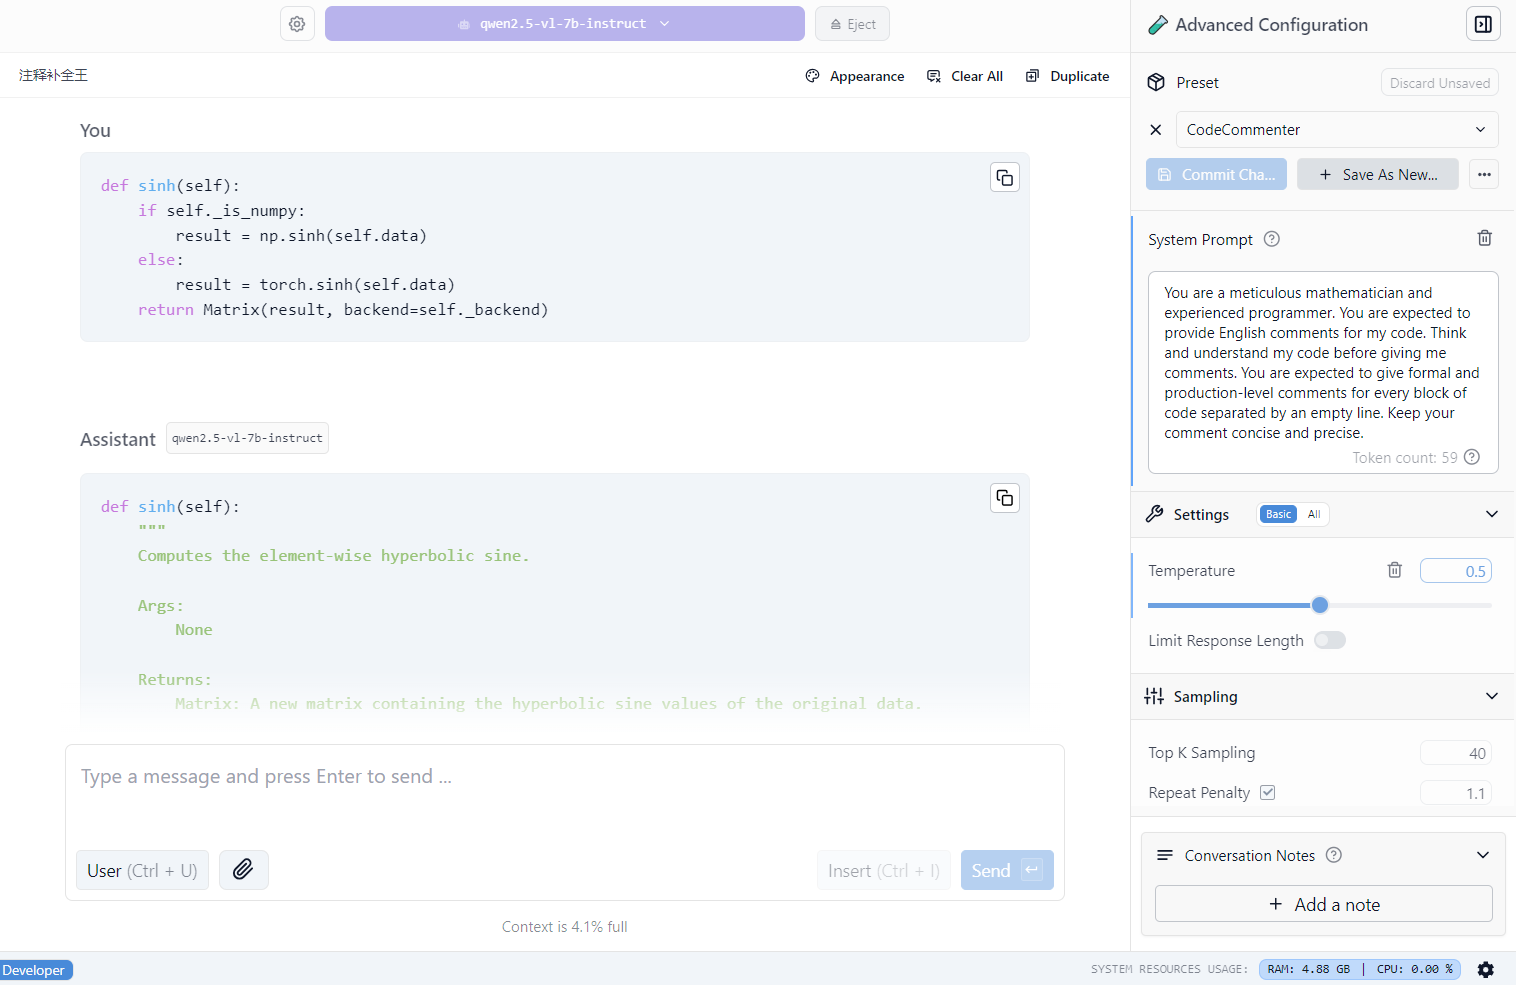

`1. Implementation (PCA Class)`

In [500]:
# This PCA class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class PCA(Regression, Classification):
    """
    Principal Component Analysis (PCA) class built upon the Matrix class.
    It performs data centering/standardization, computes the covariance matrix,
    calculates eigenvalues/eigenvectors, projects data onto principal components,
    and computes the variance explained.
    """
    
    def __init__(self, n_components=None, method="centralize", eigen_method="selfimpl"):
        """
        Initializes the PCA class.
        
        Args:
            n_components (int): Number of principal components to keep. If None, all components are kept.
            method (str): Method for scaling the data ('centralize', 'normalize',or 'minmax'). Default is 'centralize'.
            eigen_method(str): Method for eigenvalues/eigenvectors calculation ('selfimpl', 'kernel'). Default is 'selfimpl'
        
        Attributes:
            n_components (int): Number of principal components to retain.
            eigen_method(str): Method for eigenvalues/eigenvectors calculation.
            scaling (Scaling): An instance of Scaling class used for centering and standardizing the data.
            cov_matrix (Matrix): Matrix containing the covariance matrix of the training matrix.
            components (Matrix): Matrix containing the principal components.
            eigenvalues (Matrix): Eigenvalues corresponding to each principal component.
            eigenvectors (Matrix): Eigenvectors corresponding to each principal component.
            explained_variance_ratio (Matrix): The proportion of variance explained by each principal component.
        
        Raises:
            ValueError: If an unsupported scaling method is provided. Choose 'centralize' or 'minmax'.
        
        """
        self.n_components = n_components
        self.eigen_method = eigen_method
        self.scaling = Scaling(method=method)
        # Principal components
        self.cov_matrix = None
        self.components = None
        self.eigenvalues = None
        self.eigenvectors = None
        # Statistical results
        # Implemented by Nathmath Huang
        self.explained_variance_ratio = None
        
    def fit(self, X: Matrix, sample_cov:bool = True):
        """
        Fits the PCA model to the input data.
        
        Args:
            X (Matrix): The matrix of features.
            sample_cov (bool): Whether to compute the sample covariance. Default is True.
        
        Returns:
            self: The fitted instance of the class, allowing method chaining.
        
        Raises:
            TypeError: If `X` is not a Matrix or Tensor type due to eigen computation requirements.
        
        """
        # Not a matrix
        if isinstance(X, Matrix) == False:
            if isinstance(X, Tensor) == True:
                raise TypeError("PCA class only accept `Matrix` type due to eigen computation. Convert your Tensor to Matrix by using X = Matrix(X.data)")
            else:
                raise TypeError(f"PCA class only accept `Matrix` instead of {type(X)}")
                
        # Data centering/standardization
        self.scaling.fit(X = X, axis = 0)
        X_centered = self.scaling.transform(X).to(backend=X._backend, dtype=X.dtype)

        # Covariance matrix computation
        n_samples = X.shape[0]
        X_centered_T = X_centered.transpose()
        self.cov_matrix = (X_centered_T @ X_centered) / (n_samples - 1 if sample_cov == True else 0)
        
        # Eigenvalue/eigenvector calculation (use my implementation in Matrix)
        eigenvalues, eigenvectors = self.cov_matrix.eigen(method=self.eigen_method)
        # Note:
        # The Eigen values and vectors here MIGHT be in complex form.
        # So, call .to_rational() to forcefully transform into rational numbers.
        # Moreover, ensures all of the tensors are on the same device.
        eigenvalues = eigenvalues.to_rational().copy().to(backend=X._backend, dtype=X.dtype, device=X.device)
        eigenvectors = eigenvectors.to_rational().copy().to(backend=X._backend, dtype=X.dtype, device=X.device)
        
        # Sort them in descending order
        if eigenvalues._is_numpy:
            sorted_idx = np.argsort(eigenvalues.data)[::-1]
            eigenvalues = eigenvalues[sorted_idx]
            eigenvectors = eigenvectors[:, sorted_idx]
        else:
            sorted_idx = torch.argsort(eigenvalues.data, descending=True)
            eigenvalues = eigenvalues[sorted_idx]
            eigenvectors = eigenvectors[:, sorted_idx]
            
        # Save the eigen values and eigen vectors
        self.eigenvalues = eigenvalues.copy(dtype=X.dtype, device=X.device)
        self.eigenvalues = eigenvectors.copy(dtype=X.dtype, device=X.device)      
            
        # Select the top n_components if specified
        if self.n_components is not None:
            components_eigenvalues = eigenvalues[:self.n_components]
            components_eigenvectors = eigenvectors[:, :self.n_components]
        self.components = components_eigenvectors.copy(dtype=X.dtype, device=X.device) 

        # Variance explained
        total_variance = eigenvalues.sum()
        self.explained_variance_ratio = (components_eigenvalues / total_variance).copy(dtype=X.dtype, device=X.device) 
        return self

    def predict(self, X: Matrix):
        """
        Projects the input matrix `X` onto the principal components learned during fit.
        
        Args:
            X (Matrix): The matrix of features for prediction.
        
        Returns:
            projected (Matrix): The transformed data in the new coordinate system defined by the principal components.
        
        Raises:
            TypeError: If `X` is not a Matrix type due to eigen computation requirements.
            TypeError: If the model has not been fitted (`components` is None).
            ValueError: If the number of features in `X` does not match the number of columns in the covariance matrix.
        
        """
        
        # Not a matrix
        if isinstance(X, Matrix) == False:
            if isinstance(X, Tensor) == True:
                raise TypeError("PCA class only accept `Matrix` type due to eigen computation. Convert your Tensor to Matrix by using X = Matrix(X.data)")
            else:
                raise TypeError(f"PCA class only accept `Matrix` instead of {type(X)}")
                
        # Not fitted
        if self.components is None:
            raise TypeError("You must call `fit` before calling this `predict`")
            
        # Dimension mismatch
        if X.shape[1] != self.cov_matrix.shape[1]:
            raise ValueError(f"You must give a matrix `X` having exactly the same number of features of {self.cov_matrix.shape[1]}")
                
        # Project data onto principal components
        X_centered = self.scaling.transform(X).to(backend=self.components._backend, dtype=self.components.dtype, device=self.components.device)
        projected = X_centered @ self.components
        return projected

    def fit_predict(self, X: Matrix):
        """
        Fits the PCA model to the input data and then predicts the transformed data.
        
        Args:
            X (Matrix): The matrix of features for both fitting and prediction.
        
        Returns:
            projected (Matrix): The transformed data in the new coordinate system defined by the principal components.
        
        Raises:
            TypeError: If `X` is not a Matrix type due to eigen computation requirements.
        
        """
        
        # Not a matrix
        if isinstance(X, Matrix) == False:
            if isinstance(X, Tensor) == True:
                raise TypeError("PCA class only accept `Matrix` type due to eigen computation. Convert your Tensor to Matrix by using X = Matrix(X.data)")
            else:
                raise TypeError(f"PCA class only accept `Matrix` instead of {type(X)}")
                
        self.fit(X)
        return self.predict(X)

    def variance_explained(self):
        """
        Returns the explained variance ratio for each principal component.
        
        Returns:
            explained_variance_ratio (Matrix): The proportion of variance in `X` that is explained by each principal component.
        
        """
        # Note this is a Matrix
        return self.explained_variance_ratio 
    
# !!!
# Comments about points in the 1st part of this assignment:
# 
# > Data centering/standardization 
# ---> I have detached the scaling functionality aside from the PCA class,
# ---> which is implemented in the Scaling class.
# ---> For PCA, we recommend to use `normalize` method to de-mean and standarize the data.
# 
# > Covariance matrix computation
# ---> Calculation covariance matrix by the de-meaned data is implemented in 
# ---> this PCA class and in the `fit` method.
# ---> You may use numpy or torch as the backend for matrix operations.
# 
# > Eigenvalue/eigenvector calculation
# ---> Eigen calculation is implemented in the `Matrix` class. You may choose
# ---> to call the built-in libraries to calculate, but by default, you get
# ---> the self-implemented eigenvalues and eigenvectors with `method` set to
# ---> `selfimpl`. I have checked and ensured the results are in consistent with
# ---> results from either numpy or torch.
#
# > Projection of data onto principal components
# ---> I have separate the fitting and transformming processes. For projection
# ---> of data, please refer to class `PCA`s `predict` method.
#
# > Variance explained calculation
# ---> The variance explained is calculated in the `fit` method, as measured
# ---> by the sum of the principal components over the sum of all eigenvalues.

`1.5 Load Data into the Notebook Environment`

In [501]:
# Load the provided wine dataset
#

# Define the URL.
red_wine_url = 'https://raw.githubusercontent.com/dof-studio/dtafina/refs/heads/main/MachineLearning/winequality-red.csv'
white_wine_url = "https://raw.githubusercontent.com/dof-studio/dtafina/refs/heads/main/MachineLearning/winequality-white.csv"

# Load the raw wine dataset into a pandas DataFrame.
raw_red_wine = pd.read_csv(red_wine_url, sep=";")
raw_white_wine = pd.read_csv(white_wine_url, sep=";")

# Merge those two wines together by adding a type column (1 for red, 0 for white).
added_red_wines = raw_red_wine; added_red_wines["type"] = 1
added_white_wines = raw_white_wine; added_white_wines["type"] = 0
merged_wines = pd.concat([added_red_wines, added_white_wines])

# Astype into float32.
merged_wines = merged_wines.astype("float32")
merged_wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6.0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6.0,0.0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5.0,0.0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6.0,0.0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7.0,0.0


In [502]:
# Split into features and target Matrix
# 

# Split features out of the merged_wines DataFrame.
features_wine = Matrix(data = merged_wines.drop("quality", axis = 1).to_numpy(), backend=backend)
features_wine = features_wine.to(backend = backend, device = device)

# Split target out of the merged_wines DataFrame.
target_wine = Matrix(data = pd.DataFrame(merged_wines["quality"]).to_numpy(), backend=backend)
target_wine = target_wine.to(backend = backend, device = device)
target_wine = target_wine.reshape([target_wine.shape[0], 1])

# Display the tuple.
(features_wine, target_wine)

(Matrix(backend=numpy, shape=(6497, 12), data=
 [[ 7.4   0.7   0.   ...  0.56  9.4   1.  ]
  [ 7.8   0.88  0.   ...  0.68  9.8   1.  ]
  [ 7.8   0.76  0.04 ...  0.65  9.8   1.  ]
  ...
  [ 6.5   0.24  0.19 ...  0.46  9.4   0.  ]
  [ 5.5   0.29  0.3  ...  0.38 12.8   0.  ]
  [ 6.    0.21  0.38 ...  0.32 11.8   0.  ]]),
 Matrix(backend=numpy, shape=(6497, 1), data=
 [[5.]
  [5.]
  [5.]
  ...
  [6.]
  [7.]
  [6.]]))

`2. Visualization & Analysis`

In [503]:
# Apply your PCA implementation to the provided high-dimensional dataset
# 

# Instantiate PCA to retain all of the components.
pca = PCA(n_components=12, method = "normalize", eigen_method = "selfimpl")
pca.fit(features_wine)
    
# Print the principal components.
print("Principal Components (each column is a component):")
print(pca.components)
    
# Show the total of variance explained.
print("\nExplained Variance Ratio:")
print(np.round(pca.explained_variance_ratio.sum().to("numpy").data * 100, 4), "%", sep="")

Principal Components (each column is a component):
Matrix(backend=numpy, shape=(12, 12), data=
[[ 2.57017374e-01 -2.72711813e-01  4.50201750e-01 -1.65191188e-01
   1.54164612e-01  2.15681404e-01  2.76035786e-01 -3.33733290e-01
   1.71727821e-01 -4.70121086e-01  2.19619021e-01  2.70194262e-01]
 [ 3.58867526e-01 -3.40829603e-02 -2.86619902e-01 -2.17380866e-01
  -1.48704350e-01  4.86690849e-01  2.40559146e-01  1.81042567e-01
  -5.66834092e-01  1.17976204e-01  2.35601187e-01  1.71392709e-02]
 [-1.14202000e-01 -2.07374290e-01  5.85204124e-01  2.67282218e-01
   1.60007626e-01 -1.99315622e-01  3.47354621e-01  3.49704474e-01
  -3.45054060e-01  3.20363760e-01  6.05989655e-04  8.77212361e-03]
 [-2.45921999e-01 -3.97785842e-01 -1.72743395e-01 -1.65083796e-01
   3.56529057e-01  1.86194345e-01 -3.15605581e-01  4.82668340e-01
   1.42865390e-01  2.54919776e-03  5.57289757e-02  4.54220444e-01]
 [ 2.95318246e-01 -2.41181031e-01  6.82494882e-03  2.37107262e-01
  -6.41026020e-01 -1.62692621e-01 -1.323505

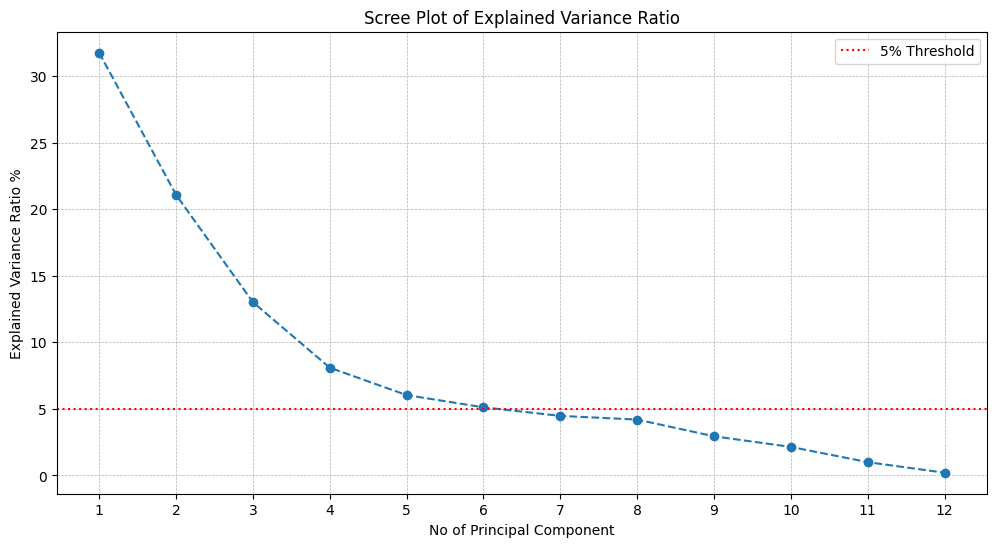

In [504]:
# Create a scree plot showing explained variance by each principal component.
#

# Plot the explained variance ratio for each component
plt.figure(figsize=(12, 6))
plt.plot(range(1, pca.n_components + 1), pca.variance_explained().to("numpy").data * 100, marker='o', linestyle='--')

# Add a 1% threshold
plt.axhline(y=5, color='red', linestyle=':', label='5% Threshold')
plt.xlabel('No of Principal Component')
plt.ylabel('Explained Variance Ratio %')
plt.title('Scree Plot of Explained Variance Ratio')
plt.xticks(range(1, pca.n_components + 1))
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

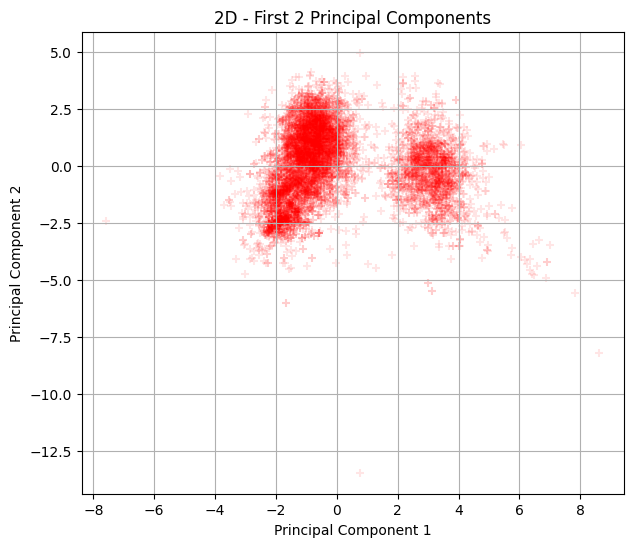

In [505]:
# Visualize data in 2D and 3D using the top principal components
# 

# Transform the high-dimensional dataset by method predict.
projected_data = pca.predict(features_wine)

# 2D Visualization using the top 2 principal components.
plt.figure(figsize=(7, 6))
plt.scatter(projected_data[:, 0].to("numpy").data, projected_data[:, 1].to("numpy").data, 
            c='red', marker='+', alpha=0.10)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D - First 2 Principal Components')
plt.grid(True)
plt.show()

# Why two parts?
# I have merged the red wine and white wine together and I found 
# the type (red/white) accounts a lot for the quality.

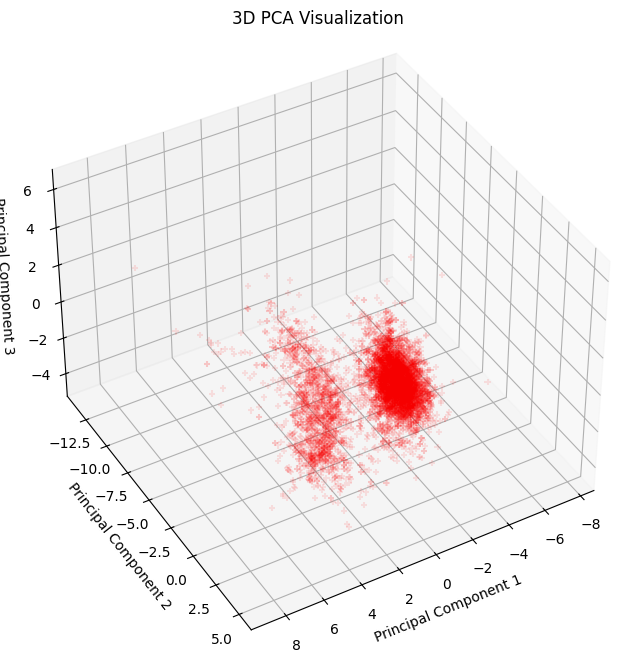

In [506]:
# Visualize data in 2D and 3D using the top principal components
# 

# 3D Visualization using the top 3 principal components.
fig = plt.figure(figsize=(10, 8))
pca3dplot = fig.add_subplot(111, projection='3d')

# I have adjusted elev=40 and azim=30 to best view the changes in the 3 dimensions.
pca3dplot.view_init(elev=40, azim=60)
pca3dplot.scatter(projected_data[:, 0].to("numpy").data, projected_data[:, 1].to("numpy").data, projected_data[:, 2].to("numpy").data,
             c='red', marker='+', alpha=0.10)
pca3dplot.set_xlabel('Principal Component 1')
pca3dplot.set_ylabel('Principal Component 2')
pca3dplot.set_zlabel('Principal Component 3')
pca3dplot.set_title('3D PCA Visualization')
plt.show()

# Why two parts?
# I have merged the red wine and white wine together and I found 
# the type (red/white) accounts a lot for the quality.

`3. Parameter Analysis`

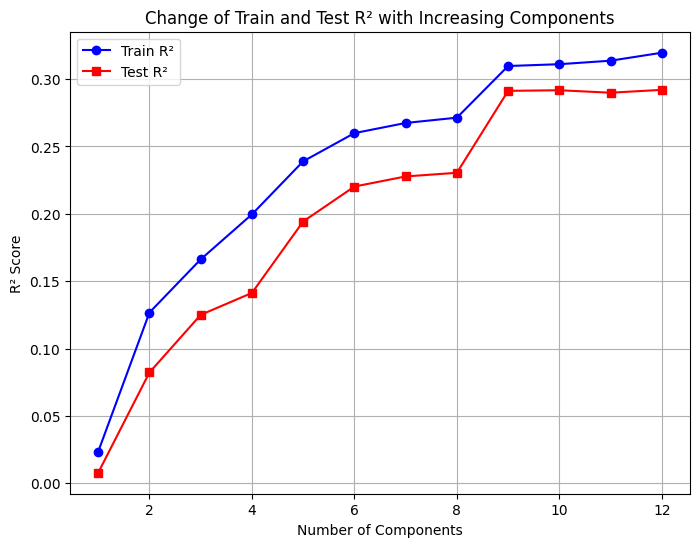

In [510]:
# The Simplest Model - Linear Polynomial Regression - to study how changing the number of components affects
# 

# Train-test split using PCA's method.
X_train_raw, X_test_raw, y_train_raw, y_test_raw = pca.train_test_split(projected_data, target_wine, test_size = 0.2, random_state = 2821)

# Add polynomials or sigmoid polynomial.
def add_polynomial(X: Matrix | Tensor, idx_range: int, power: int | str = 2, axis: int = 1):
    '''
    power: int: the number of power to raise.
           str: "logistic", apply logistic (sigmoid) function
    axis: 1 = column
          0 = row
    '''
    X_new = type(X)(X.data, X._backend, device=X.device)
    if isinstance(power, int):
        for i in range(idx_range):
            X_new = X_new.append(X_new[:,i].reshape([X_new[:,i].shape[0], 1]) ** power, axis=axis)
    elif power == "logistic":
        for i in range(idx_range):
            X_new = X_new.append(X_new[:,i].reshape([X_new[:,i].shape[0], 1]).logistic(), axis=axis)
    return X_new
    
# Perform a linear polynomial regression and return the train_rmse, test_rmse.
def linear_polynomial(X_train_raw: Matrix | Tensor,
                      X_test_raw: Matrix | Tensor, 
                      y_train_raw: Matrix | Tensor, 
                      y_test_raw: Matrix | Tensor,
                      n_components: int = 3, 
                      order: List[int | str] = [2], 
                      add_constant = True, 
                      metrics = "RMSE"):

    X_train_selected = X_train_raw[:, 0:n_components]
    X_test_selected = X_test_raw[:, 0:n_components]
    y_train_selected = y_train_raw.reshape([y_train_raw.shape[0], 1])
    y_test_selected = y_test_raw.reshape([y_test_raw.shape[0], 1])

    for i in order:
        X_train_selected = add_polynomial(X_train_selected, n_components, i, axis=1)
        X_test_selected = add_polynomial(X_test_selected, n_components, i, axis=1)

    # Add constants if required.
    if add_constant == True:
        X_train_selected = X_train_selected.append(1, axis=1)
        X_test_selected = X_test_selected.append(1, axis=1)

    # Fit a linear polynomial regression.
    b = Matrix.least_square(X_train_selected, y_train_selected, backend=X_train_selected._backend)

    # Evalute metrics on train set and test set.
    train_metrics = RegressionMetrics(X_train_selected @ b, y_train_selected, metrics)
    test_metrics = RegressionMetrics(X_test_selected @ b, y_test_selected, metrics)
    
    return train_metrics.compute(), test_metrics.compute()

# Collect train_r2 and test_r2 by iterating the number of components.
train_r2 = []
test_r2 = []
for n in range(1, 13, 1):
    r2_tuple = linear_polynomial(X_train_raw, X_test_raw, y_train_raw, y_test_raw, n_components=n, order=["logistic"], metrics="R2")
    train_r2.append(r2_tuple[0].flatten().to("numpy").data[0])
    test_r2.append(r2_tuple[1].flatten().to("numpy").data[0])

# Plot a line graph to show how R2 changes as the number of components change.
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_r2) + 1), train_r2, marker='o', label='Train R²', color='blue')
plt.plot(range(1, len(train_r2) + 1), test_r2, marker='s', label='Test R²', color='red')
plt.xlabel('Number of Components')
plt.ylabel('R² Score')
plt.title('Change of Train and Test R² with Increasing Components')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Analysis of results and insights
# 

# > Trend
# The plotted results reveal a clear upward trend in both train and test R² values 
# as the number of predictors increases, indicating improved model performance initially. 
# 
# > When to stop
# The train R² consistently rises, while the test R² shows a peak around the 9th predictor 
# before starting to decline slightly. This divergence suggests the model may begin overfitting 
# beyond this point, where additional predictors improve training performance but 
# harm generalization. 
# 
# More general conclusion:
# > Adding PCA components will always enhance the interpretability of the dataset.
# > However, for specific models, especially those prone to overfitting, excessive principal 
# components introduce more details from the training set, potentially leading to overfitting.

`End of Homework 1 Q2 by Nathmath Huang (bh2821)`